## Food Nutrition

Import library

In [170]:
import random
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import matplotlib.image as mpimg
from sklearn.metrics  import confusion_matrix, classification_report
import seaborn as sns


# Preprocessing

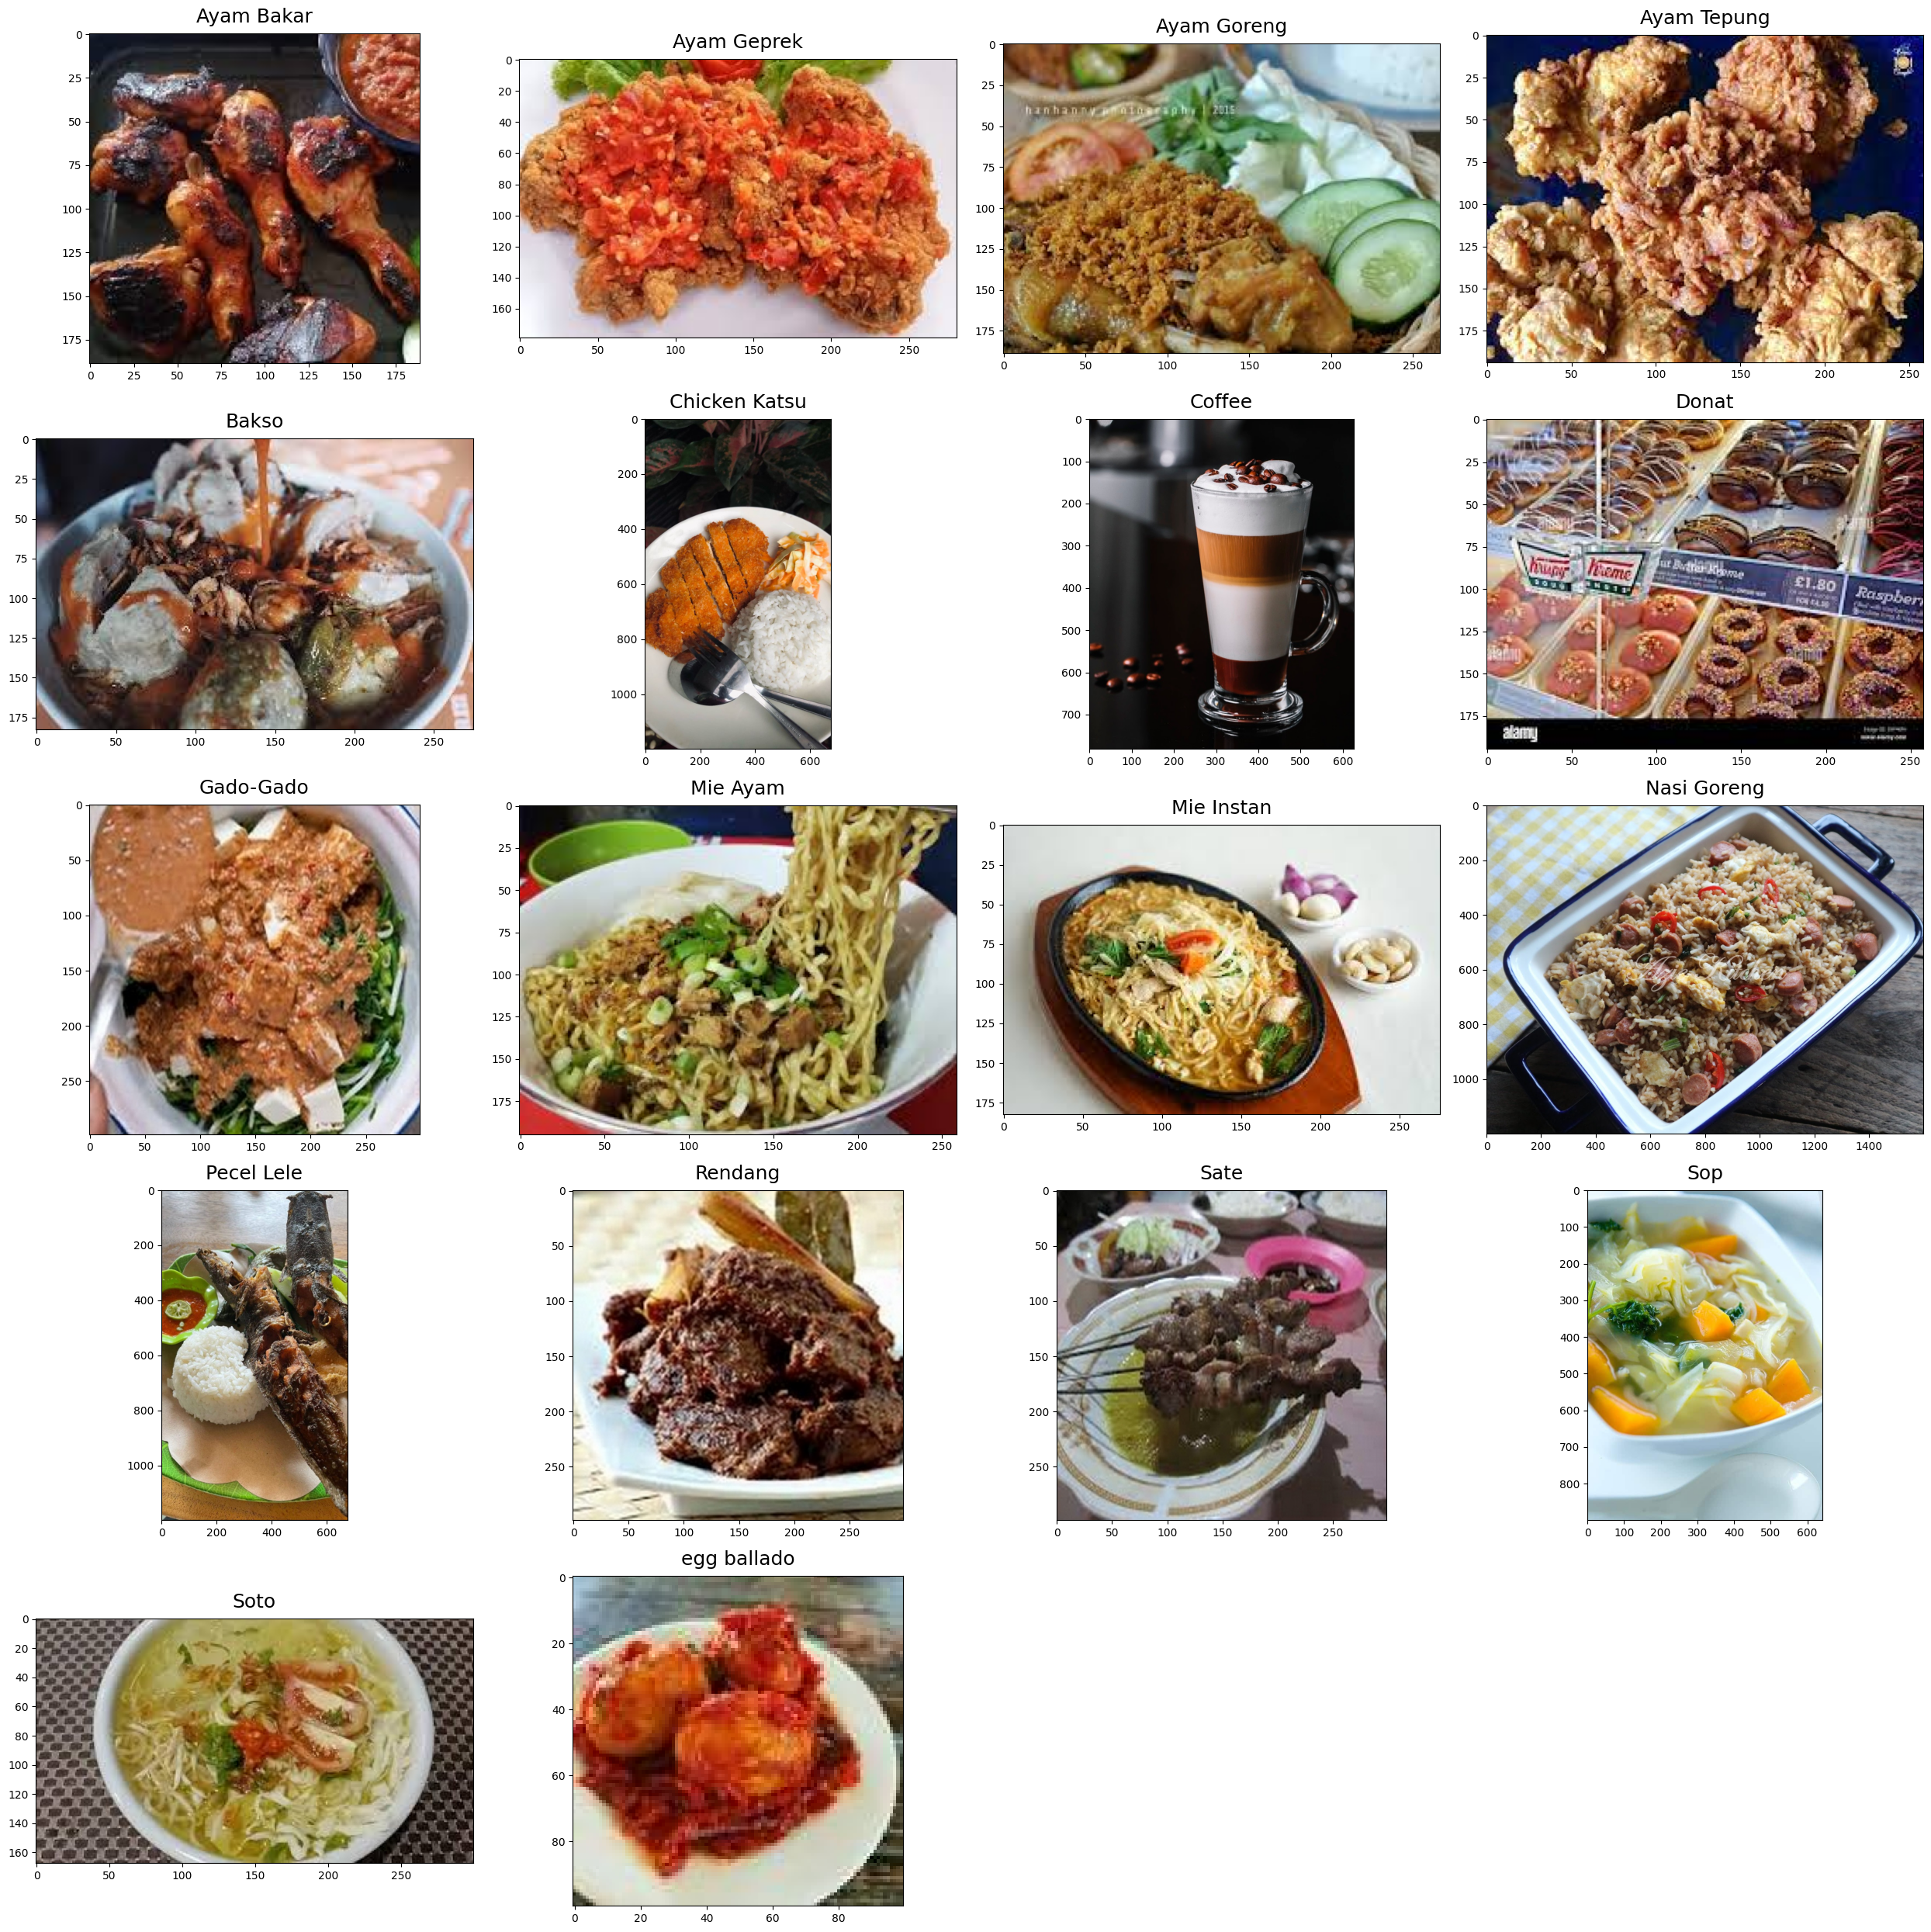

In [171]:
train_dir = "Image Eye/Train"
test_dir = "Image Eye/Test"
images = []

for food_folder in sorted(os.listdir(train_dir)):
    food_items = os.listdir(train_dir + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_dir,food_folder,food_selected))

fig=plt.figure(1, figsize=(25, 25))

for subplot,image_ in enumerate(images):
    category=image_.split('\\')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(5, 4, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)

plt.tight_layout()

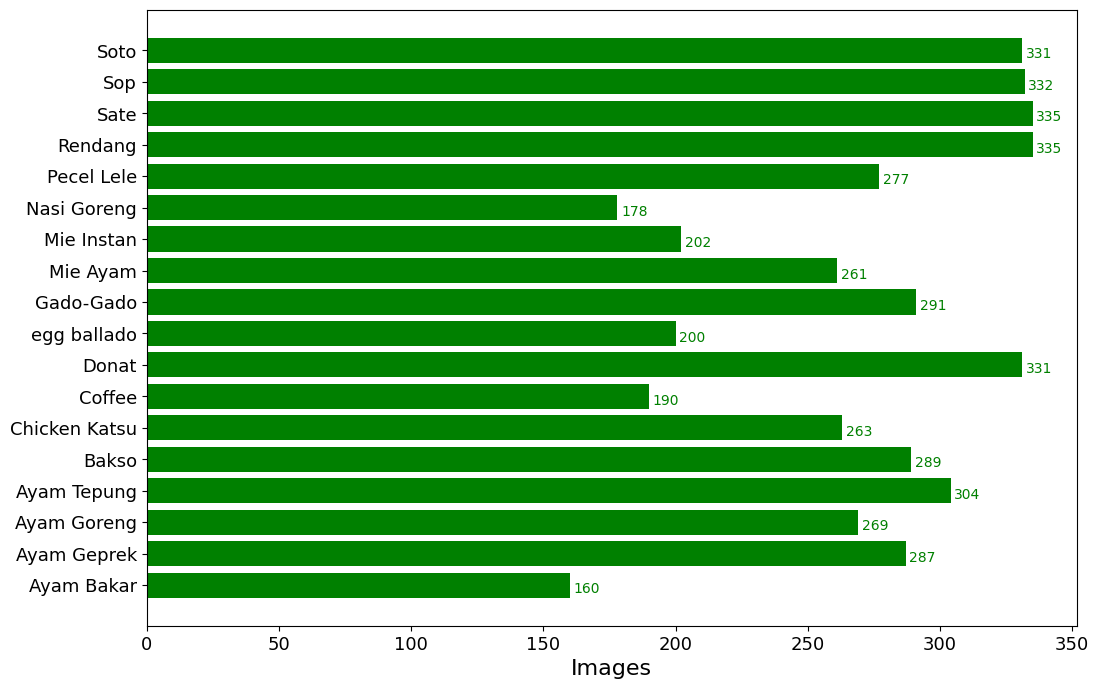

In [172]:
data=dict()

for i in os.listdir(train_dir):
    sub_dir=os.path.join(train_dir,i)
    count=len(os.listdir(sub_dir))
    data[i]=count
    
  
keys = data.keys()
values = data.values()

colors=["red" if x<= 150 else "green" for x in values]

fig, ax = plt.subplots(figsize=(12,8))
y_pos=np.arange(len(values))
plt.barh(y_pos,values,align='center',color=colors)
for i, v in enumerate(values):
    ax.text(v+1.4, i-0.25, str(v), color=colors[i])
ax.set_yticks(y_pos)
ax.set_yticklabels(keys)
ax.set_xlabel('Images',fontsize=16)
plt.xticks(color='black',fontsize=13)
plt.yticks(fontsize=13)
plt.show()

Data Augmentation

In [173]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./ 255,
                                                                 rotation_range=40,
                                                                 width_shift_range=0.2,
                                                                 height_shift_range=0.2,
                                                                 shear_range=0.2,
                                                                 zoom_range=0.4,
                                                                 horizontal_flip=True,
                                                                 fill_mode='nearest')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(244, 244),
                                                    batch_size=32,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(244, 244),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 4833 images belonging to 18 classes.
Found 1214 images belonging to 18 classes.


# Transfer Learning

In [174]:
import tensorflow as tf
# Loading the Pre-trained Xception Model
from tensorflow.keras.applications import Xception

# Loading the Pre-trained Xception Model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

# Checking the amount of layers
total_layers = len(base_model.layers)

# Choose the last half of the layers
fn_layers = total_layers - int(0.5 * total_layers)

# Freezing the Base Layer but retrain the last half of the layers
# for layer in base_model.layers[:fn_layers]:
#     layer.trainable = False
for layer in base_model.layers[:fn_layers]:
    layer.trainable = False    

#base_model.summary()                 

In [175]:
#Show the trainable layers
trainable_layers = [layer.name for layer in base_model.layers if layer.trainable]
print("Trainable Layers:")
for layer in trainable_layers:
    print(layer)

Trainable Layers:
block8_sepconv1_act
block8_sepconv1
block8_sepconv1_bn
block8_sepconv2_act
block8_sepconv2
block8_sepconv2_bn
block8_sepconv3_act
block8_sepconv3
block8_sepconv3_bn
add_246
block9_sepconv1_act
block9_sepconv1
block9_sepconv1_bn
block9_sepconv2_act
block9_sepconv2
block9_sepconv2_bn
block9_sepconv3_act
block9_sepconv3
block9_sepconv3_bn
add_247
block10_sepconv1_act
block10_sepconv1
block10_sepconv1_bn
block10_sepconv2_act
block10_sepconv2
block10_sepconv2_bn
block10_sepconv3_act
block10_sepconv3
block10_sepconv3_bn
add_248
block11_sepconv1_act
block11_sepconv1
block11_sepconv1_bn
block11_sepconv2_act
block11_sepconv2
block11_sepconv2_bn
block11_sepconv3_act
block11_sepconv3
block11_sepconv3_bn
add_249
block12_sepconv1_act
block12_sepconv1
block12_sepconv1_bn
block12_sepconv2_act
block12_sepconv2
block12_sepconv2_bn
block12_sepconv3_act
block12_sepconv3
block12_sepconv3_bn
add_250
block13_sepconv1_act
block13_sepconv1
block13_sepconv1_bn
block13_sepconv2_act
block13_sep

Learning Rate Schedhuler

In [176]:
# Customize the Learning Rate
inisiate_lr = 0.001
epochs = 20

def lr_scedhuler(epoch):
    return inisiate_lr * 0.9 ** epoch 

optimizers=tf.keras.optimizers.Adam(learning_rate=inisiate_lr)

Adding new layers to the base_model

In [177]:
model = tf.keras.models.Sequential([
  base_model,
  tf.keras.layers.GlobalMaxPooling2D(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(18, activation='softmax')  # Menggunakan softmax karena ini adalah klasifikasi multikelas
])

Compile The Model

In [178]:
model.compile(optimizer= optimizers,
              loss='categorical_crossentropy',  # Menggunakan categorical_crossentropy untuk klasifikasi multikelas
              metrics=['accuracy'])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_max_pooling2d_3 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_37 (Dense)            (None, 256)               524544    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_38 (Dense)            (None, 18)                4626      
                                                     

Create Callbacks

In [179]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.93 and logs.get('accuracy') > 0.95):
      # Stop if threshold is met
      print("\nYOU DID IT GIRLLLL, BOTH ARE HIGHER THAN 0.94 DAMN SLAYYY!! :P")
      self.model.stop_training = True

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

# Instantiate class
callbacks = myCallback()

In [180]:
#Reducing the Learning Rate if there's no progress in the loss 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

# Model Training

In [181]:
# AKURASI AWALNYA 0.2 
epochs= 10

history=model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=epochs, verbose=1, callbacks=[callbacks, reduce_lr])  # Sesuaikan jumlah langkah per epoch sesuai kebutuhan

Epoch 1/10
 16/152 [==>...........................] - ETA: 40s - loss: 3.1562 - accuracy: 0.0723

KeyboardInterrupt: 

# Model Evaluate

Checking the F1 score

In [ ]:
from sklearn.metrics import f1_score

# Melakukan prediksi pada data uji
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Menggunakan argmax untuk mendapatkan kelas prediksi
y_pred_classes = np.argmax(y_pred, axis=1)

# Menghitung F1 score
f1score = f1_score(y_true, y_pred_classes, average='weighted')

print("F1 Score:", f1score)

10/10 [==============================] - 2s 174ms/step
F1 Score: 0.01326286398085361


Plot of The Model

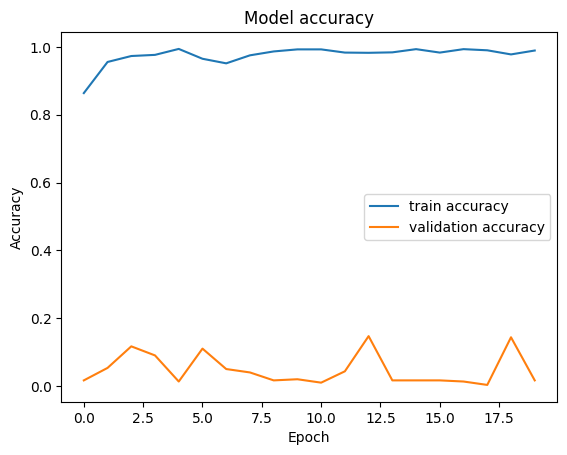

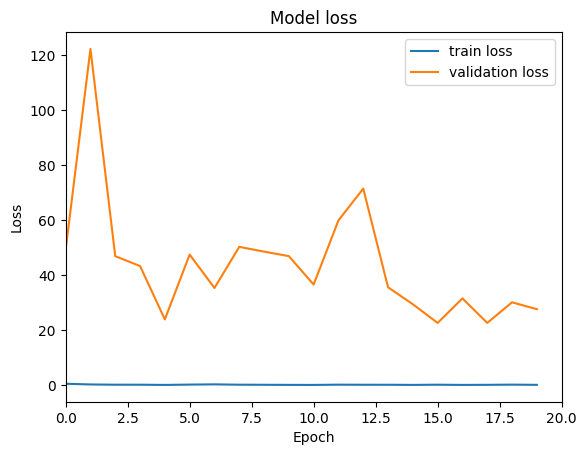

In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xlim(0, epochs )
    #plt.ylim(0,100)
    plt.legend(loc='best')
    plt.show()

plot_accuracy(history)
plot_loss(history)

Confusion Matrix

In [ ]:
predictions = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(test_generator.labels, predictions)
clr = classification_report(test_generator.labels, predictions, target_names=test_generator.class_indices, zero_division=0)

10/10 [==============================] - 2s 176ms/step


ValueError: The number of FixedLocator locations (18), usually from a call to set_ticks, does not match the number of labels (5).

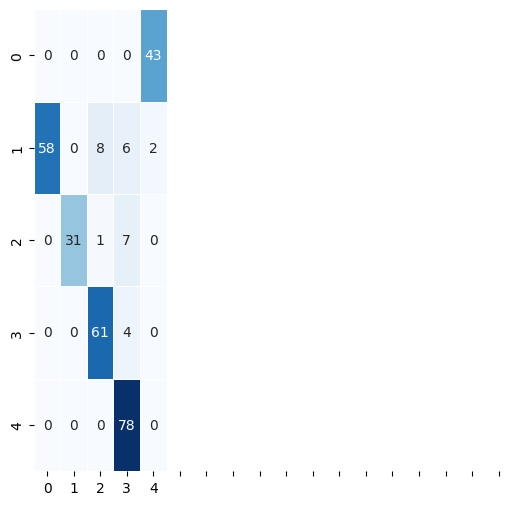

In [ ]:
plt.figure(figsize=(6,6))
#sns.heatmap(cm, annot=True, fmt='d', vmin=0, plt.cm.colors.ListedColormap(['#FFC0CB']), cbar=False, linewidths=.5)
sns.heatmap(cm, annot=True, fmt='d', vmin=0, cmap='Blues', cbar=False, linewidths=.5)
plt.xticks(ticks=np.arange(18) + 0.5, labels=test_generator.class_indices, rotation=90)
plt.yticks(ticks=np.arange(18) + 0.5, labels=test_generator.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
clr = classification_report(test_generator.labels, predictions, target_names=test_generator.class_indices, zero_division=0)
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

   Ayam Bakar       0.03      0.03      0.03        68
  Ayam Geprek       0.06      0.06      0.06        68
  Ayam Goreng       0.06      0.05      0.06        74
  Ayam Tepung       0.05      0.05      0.05        59
        Bakso       0.04      0.04      0.04        69
Chicken Katsu       0.05      0.04      0.05        69
       Coffee       0.07      0.12      0.09        43
        Donat       0.06      0.03      0.04        74
    Gado-Gado       0.06      0.13      0.09        39
     Mie Ayam       0.04      0.06      0.05        70
   Mie Instan       0.08      0.05      0.06        80
  Nasi Goreng       0.07      0.08      0.07        66
   Pecel Lele       0.08      0.08      0.08        60
      Rendang       0.07      0.08      0.07        65
         Sate       0.04      0.04      0.04        78
          Sop       0.05      0.06      0.05        67
         Soto    

# Model Predict

In [185]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt

# class_labels = ["Ayam Bakar", "Ayam Geprek", "Ayam Goreng", "Ayam Tepung", "Bakso","Chicken Katsu", "Egg Ballado", 
#                 "Mie Ayam", "Mie Instan", "Nasi Goreng", "Pecel Lele", "Sop", "Soto",'Rendang',"Sate",'Gado-Gado','Coffee',"Donat"]
class_labels = (test_generator.class_indices)

# Path to the directory containing your test images
test_dir = os.path.join('Image Eye','Dev') 

# Get a list of all image files in the test directory
image_paths = [os.path.join(test_dir, file) for file in os.listdir(test_dir) if file.endswith(('.jpg', '.png', '.jpeg'))]

# image_paths = ["./Image Eye/Train/egg ballado/telurBalado Train (10).jpeg"]

for image_path in image_paths:
    # Load and preprocess the image using Pillow (PIL)
    img = load_img(image_path, target_size=(244, 244))  # Load and resize the image
    x = img_to_array(img)  # Convert the image to a NumPy array
    x = x / 255.0  # Normalize the pixel values to the range [0, 1]

    # Predict using the model
    yhat = model.predict(np.expand_dims(x, axis=0))
    predicted_class = np.argmax(yhat, axis=1)[0]
    predicted_label = class_labels[predicted_class]

    fig, ax = plt.subplots(nrows=2, ncols=1)  # Membuat subplots dengan 2 baris dan 1 kolom
    fig.suptitle(f'Class: {image_path}')
    fig.suptitle(f'Predicted class: {predicted_label}')
    
    # Menampilkan gambar di subplot pertama
    ax[0].imshow(x)  
    # Menampilkan kelas prediksi di subplot kedua
    ax[1].bar(class_labels, yhat.flatten())
    ax[1].set_title('Prediction Probability')
    ax[1].set_xlabel('Class')
    ax[1].set_ylabel('Probability')

    ax[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

    print(f'Predicted class for {image_path} is {predicted_label}')
    #print(f'Class index: {predicted_class}')

    #plt.imshow(x)  # Display the resized image
    #plt.title(f'Predicted class: {predicted_label}')
    #plt.show()

1/1 [==============================] - 0s 412ms/step


KeyError: 16

In [184]:
(train_generator.class_indices)

{'Ayam Bakar': 0,
 'Ayam Geprek': 1,
 'Ayam Goreng': 2,
 'Ayam Tepung': 3,
 'Bakso': 4,
 'Chicken Katsu': 5,
 'Coffee': 6,
 'Donat': 7,
 'Gado-Gado': 8,
 'Mie Ayam': 9,
 'Mie Instan': 10,
 'Nasi Goreng': 11,
 'Pecel Lele': 12,
 'Rendang': 13,
 'Sate': 14,
 'Sop': 15,
 'Soto': 16,
 'egg ballado': 17}

In [183]:
test_generator.class_indices

{'Ayam Bakar': 0,
 'Ayam Geprek': 1,
 'Ayam Goreng': 2,
 'Ayam Tepung': 3,
 'Bakso': 4,
 'Chicken Katsu': 5,
 'Coffee': 6,
 'Donat': 7,
 'Gado-Gado': 8,
 'Mie Ayam': 9,
 'Mie Instan': 10,
 'Nasi Goreng': 11,
 'Pecel Lele': 12,
 'Rendang': 13,
 'Sate': 14,
 'Sop': 15,
 'Soto': 16,
 'egg ballado': 17}

https://www.kaggle.com/code/mehrdadsadeghi/fashionmnist-cnn-with-tensorflow-confusionmatrix

# Model Saved

In [ ]:
# Save the model
#from tensorflow.keras.models import load_model
#model.save('foodnutrition.h5')

finished!! :D